In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import joblib


df = pd.read_excel("/Users/zhiranbai/Downloads/补充混合+板换+冷机水流量.xlsx")





In [3]:
#训练板换模型

# Define the columns that need to be converted to numeric and handled for NaNs/zeros
columns_to_convert = ['冷冻水流量', '冷却水流量', '板换冷却回水温度', '板换冷冻回水温度', '室外干球', '板换冷却出水温度', '板换冷冻出水温度']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove rows with any zeros or NaNs in these columns
df = df[~(df[columns_to_convert].isin([0]) | df[columns_to_convert].isna()).any(axis=1)]

# Filter rows based on the '运行模式' column conditions without adding 'coolDemand_chiller'
df = df[df['运行模式'].isin(['板换模式', '混合模式'])]

# Since there's no further filtering on 'coolDemand_chiller', we can directly extract X and Y
X = df[['冷冻水流量', '冷却水流量', '板换冷却回水温度', '板换冷冻回水温度', '室外干球']].values
Y = df[['板换冷却出水温度', '板换冷冻出水温度']].values

# Convert X and Y to numpy arrays of type float (though this might be redundant if the DataFrame has already enforced float types)
X = np.array(X, dtype=float)
Y = np.array(Y, dtype=float)


# print("NaN in Y:", np.isnan(X).any())


# Normalize the data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

joblib.dump(scaler_X, '/Users/zhiranbai/Downloads/plate_scaler_X.pkl')
joblib.dump(scaler_Y, '/Users/zhiranbai/Downloads/plate_scaler_Y.pkl')
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42)

# Convert arrays to PyTorch tensors
X_train_torch = torch.tensor(X_train.astype(np.float32))
Y_train_torch = torch.tensor(Y_train.astype(np.float32))
X_test_torch = torch.tensor(X_test.astype(np.float32))
Y_test_torch = torch.tensor(Y_test.astype(np.float32))

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_torch, Y_train_torch)
test_dataset = TensorDataset(X_test_torch, Y_test_torch)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)



import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 2)

        # Initialize weights using He initialization suited for ReLU
        init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.fc3.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.fc4.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.fc5.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.fc6.weight, mode='fan_out', nonlinearity='relu')
        # For the final layer, we use a general initialization as it does not use ReLU
        init.xavier_normal_(self.fc7.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        output = self.fc7(x)  # No activation function here, assuming a regression task
        
       
        return output
        

model = Net()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
for epoch in range(400):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

model.eval()  # Set the model to evaluation mode
total_loss = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches
print(f'Average Loss on the Test Set: {average_loss}')

torch.save(model.state_dict(), '/Users/zhiranbai/Downloads/plate_model_weights.pth')

Net(
  (fc1): Linear(in_features=5, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=16, bias=True)
  (fc6): Linear(in_features=16, out_features=8, bias=True)
  (fc7): Linear(in_features=8, out_features=2, bias=True)
)
Epoch 1, Loss: 0.0006975627038627863
Epoch 2, Loss: 0.0003377629618626088
Epoch 3, Loss: 0.0003205211251042783
Epoch 4, Loss: 0.00039910769555717707
Epoch 5, Loss: 0.0002666340151336044
Epoch 6, Loss: 0.0002653171541169286
Epoch 7, Loss: 0.0007391587132588029
Epoch 8, Loss: 0.0004193678614683449
Epoch 9, Loss: 0.00026788958348333836
Epoch 10, Loss: 0.0002783333184197545
Epoch 11, Loss: 0.00022864747734274715
Epoch 12, Loss: 0.00018025316239800304
Epoch 13, Loss: 0.0002133035595761612
Epoch 14, Loss: 0.00029502235702238977
Epoch 15, Loss: 0.00021456634567584842
Epoch 

Epoch 201, Loss: 0.00014533413923345506
Epoch 202, Loss: 0.0001789893431123346
Epoch 203, Loss: 9.481899905949831e-05
Epoch 204, Loss: 0.00012693116150330752
Epoch 205, Loss: 0.00018442784494254738
Epoch 206, Loss: 0.0001534720795461908
Epoch 207, Loss: 8.570712088840082e-05
Epoch 208, Loss: 0.00014515577640850097
Epoch 209, Loss: 5.939372204011306e-05
Epoch 210, Loss: 9.274177864426747e-05
Epoch 211, Loss: 9.213793964590877e-05
Epoch 212, Loss: 0.0001944808172993362
Epoch 213, Loss: 0.00014510555774904788
Epoch 214, Loss: 0.00022388214711099863
Epoch 215, Loss: 8.911924669519067e-05
Epoch 216, Loss: 0.00027813742053695023
Epoch 217, Loss: 9.103554475586861e-05
Epoch 218, Loss: 0.00016567020793445408
Epoch 219, Loss: 0.0001332066167378798
Epoch 220, Loss: 7.682615978410468e-05
Epoch 221, Loss: 0.00012633774895220995
Epoch 222, Loss: 0.002962682629004121
Epoch 223, Loss: 0.007711278274655342
Epoch 224, Loss: 0.00013482137001119554
Epoch 225, Loss: 0.0001328655198449269
Epoch 226, Loss: 

Average Loss on the Test Set: 9.714150038907182e-05


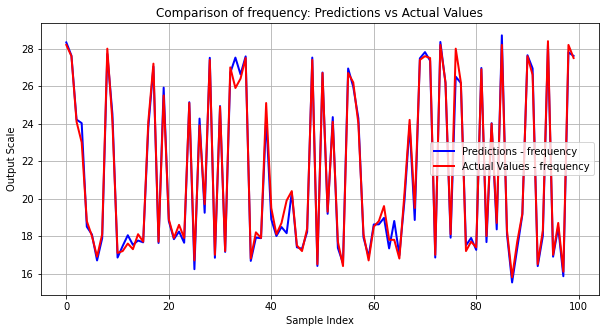

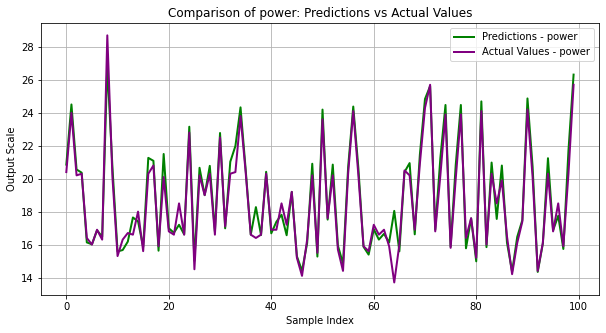

Prediction accuracy within a 10.0% threshold: 99.65%


In [6]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Assuming you have 'Net' class and data loaders already set up as per your code.

# Create an instance of the model and load weights
model = Net()
model.load_state_dict(torch.load('/Users/zhiranbai/Downloads/plate_model_weights.pth'))
model.eval()

# DataLoader for new or test data
# Assuming 'test_loader' is already defined

# Initialize the scaler for Y (assuming you have saved it after fitting)
# If scaler_Y was not saved, you must fit it again with training targets before this step
import joblib

scaler_Y = joblib.load('/Users/zhiranbai/Downloads/plate_scaler_Y.pkl')  # Make sure to save your scaler after fitting

# Predict and scale back
total_loss = 0
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        # Scale back the predictions
        outputs_np = outputs.numpy()  # Convert to NumPy array if not already
        outputs_scaled_back = scaler_Y.inverse_transform(outputs_np)
#         print(outputs_scaled_back)
        targets_np = targets.numpy()
        targets_scaled_back = scaler_Y.inverse_transform(targets_np)

        # Optional: Calculate loss for evaluation
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Store predictions and actuals for further analysis or use
        predictions.append(outputs_scaled_back)
        actuals.append(targets_scaled_back)

# Calculate and print average loss if needed
num_batches = len(test_loader)
average_loss = total_loss / num_batches
print(f'Average Loss on the Test Set: {average_loss}')
predictions[0]

predictions_first_component = [item[0] for sublist in predictions for item in sublist]
predictions_second_component = [item[1] for sublist in predictions for item in sublist]
actuals_first_component = [item[0] for sublist in actuals for item in sublist]
actuals_second_component = [item[1] for sublist in actuals for item in sublist]

# Plotting the first component
plt.figure(figsize=(10, 5))
plt.plot(predictions_first_component[0:100], label='Predictions - frequency', color='blue', linewidth=2)
plt.plot(actuals_first_component[0:100], label='Actual Values - frequency', color='red', linewidth=2)
plt.title('Comparison of frequency: Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Output Scale')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the second component
plt.figure(figsize=(10, 5))
plt.plot(predictions_second_component[0:100], label='Predictions - power', color='green', linewidth=2)
plt.plot(actuals_second_component[0:100], label='Actual Values - power', color='purple', linewidth=2)
plt.title('Comparison of power: Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Output Scale')
plt.legend()
plt.grid(True)
plt.show()

threshold = 0.10  # This means predictions within 10% of the actual values are considered accurate

# Calculate the percentage difference and check if within threshold
accurate_predictions = np.abs(np.array(predictions_first_component) - np.array(actuals_first_component)) <= threshold * np.abs(np.array(actuals_first_component))
accuracy = np.mean(accurate_predictions) * 100  # Convert fraction of accurate predictions to percentage

print(f'Prediction accuracy within a {threshold*100}% threshold: {accuracy:.2f}%')
